<a href="https://colab.research.google.com/github/hrshwrdhn/ai_cheat/blob/main/logistic_hidden_layer_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

modules

In [1]:
import torch, torchvision
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch.nn.functional as F
import torch.nn as nn


from torchvision.datasets import QMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split



Download dataset

In [2]:
dataset = QMNIST(root = 'data/',download =True , transform = ToTensor())


Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset )

60000

In [4]:
image, label = dataset[234]

0


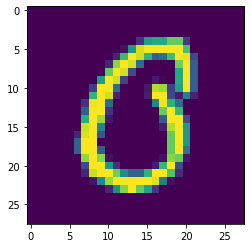

In [5]:
plt.imshow(image[0,:,:])
print(label)

# create dataloder

In [6]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds,val_ds = random_split(dataset, [train_size,val_size])


In [7]:
len(train_ds),len(val_ds)

(50000, 10000)

In [8]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers= 4, pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


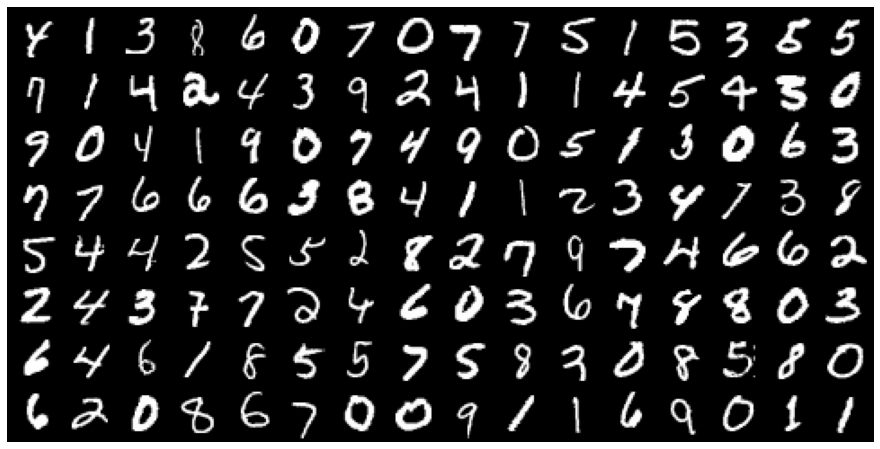

In [9]:
for images,_ in train_loader :
  print('images.shape:',images.shape)
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow = 16).permute(1,2,0) )
  break


In [10]:
class QMnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [34]:
def accuracy(outputs,labels):
  _,pred = torch.max(outputs, dim =1)
  return torch.tensor(torch.sum(pred == labels).item() / len(pred))

call model

In [12]:
input_size = 28*28
hidden_size = 32  # changable
num_classes = 10

In [15]:
model = QMnistModel(input_size,hidden_size,out_size = num_classes)

In [16]:
model

QMnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [18]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.305879831314087
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0261, -0.2069, -0.0301,  0.3320, -0.2206,  0.0979, -0.0164,  0.0710,
          0.0405, -0.1919],
        [ 0.0168,  0.0171, -0.1063,  0.2693, -0.1371,  0.0179, -0.1389, -0.0901,
          0.0212, -0.1791]])


# device cuda 

In [19]:
torch.cuda.is_available()

True

In [20]:
def get_default_device():
  """ pick cuda if gpu available else cpu """
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    torch.device('cpu')

device = get_default_device()
print(device)

cuda


In [21]:
def to_device(data,device):
  """ move tensor to choosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking =True)

In [22]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader =  DeviceDataLoader(val_loader,device)

In [27]:
for xb,yb in val_loader:
  print(xb.device)
  print(yb)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


cuda:0
tensor([9, 0, 7, 1, 7, 5, 9, 2, 3, 5, 3, 9, 7, 0, 6, 0, 8, 6, 3, 2, 0, 2, 2, 4,
        0, 9, 0, 1, 5, 3, 6, 2, 6, 3, 5, 7, 1, 6, 1, 0, 0, 4, 5, 9, 7, 7, 0, 9,
        4, 5, 4, 9, 2, 7, 9, 3, 0, 8, 0, 2, 2, 9, 4, 5, 4, 8, 3, 4, 2, 1, 4, 0,
        7, 4, 8, 3, 1, 5, 3, 8, 3, 9, 9, 2, 5, 6, 8, 8, 7, 2, 6, 5, 8, 0, 6, 7,
        1, 8, 4, 1, 2, 8, 1, 4, 1, 1, 7, 7, 9, 5, 0, 6, 1, 6, 8, 7, 4, 6, 3, 8,
        5, 1, 4, 7, 8, 3, 9, 5], device='cuda:0')


Training code

In [28]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
#model  = MnistModel(input_size,hidden_size, out_size = num_classes)
to_device(model,device)

QMnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

#Training

In [35]:
history = []
history += fit(10, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.5300, val_acc: 0.8697
Epoch [1], val_loss: 0.4599, val_acc: 0.8789
Epoch [2], val_loss: 0.4199, val_acc: 0.8862
Epoch [3], val_loss: 0.3943, val_acc: 0.8915
Epoch [4], val_loss: 0.3753, val_acc: 0.8959
Epoch [5], val_loss: 0.3612, val_acc: 0.8995
Epoch [6], val_loss: 0.3492, val_acc: 0.9019
Epoch [7], val_loss: 0.3400, val_acc: 0.9033
Epoch [8], val_loss: 0.3323, val_acc: 0.9057
Epoch [9], val_loss: 0.3247, val_acc: 0.9089


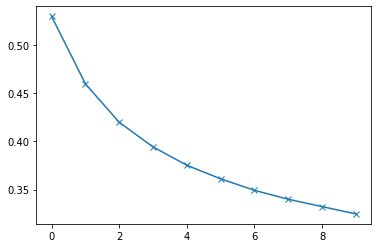

In [36]:
loss = [x['val_loss'] for x in history]
plt.plot(loss,'-x')


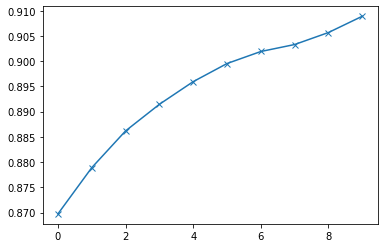

In [38]:
acc = [x['val_acc'] for x in history]
plt.plot(loss,'-x')

In [39]:
history += fit(5, 0.001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.3233, val_acc: 0.9089
Epoch [1], val_loss: 0.3226, val_acc: 0.9090
Epoch [2], val_loss: 0.3219, val_acc: 0.9091
Epoch [3], val_loss: 0.3214, val_acc: 0.9092
Epoch [4], val_loss: 0.3206, val_acc: 0.9094


In [40]:
torch.save(model.state_dict(),'qmnist_one_hiddenlayer15.pth')

In [41]:
# Define test dataset
test_dataset = QMNIST(root='data/', 
                     train=False, download = True, 
                     transform=ToTensor())



Processing...


In [42]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


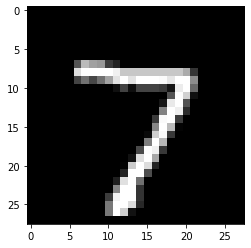

In [43]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [44]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9075243473052979, 'val_loss': 0.323565274477005}